In [1]:
import geopandas as gpd
import numpy as np
import folium
import glob
import json
import os
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from folium.plugins import HeatMap
from PIL import Image
from pyproj import CRS
from rasterio import features, Affine as A
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds, array_bounds

In [2]:
'''
Hardcoding the single image tile used in phase one to get a working POC. 
These should be changed, accessed programmatically
PATH directory should be updated to conform to the standards set out in the instructions
PATH should be updated to use os.join.path
''' 

API_KEY = 'pk.eyJ1Ijoia25lZGxpa3kiLCJhIjoiY2t0NzN4OXg4MG9ueDJvcndoM3R3bjFvayJ9.y06YZbRFunBbKyD8HuKTlw'
PATH = ('./data')
X = 7680
Y = 10240
TCI = 'TCI'
BLUE = 'B02'
GREEN = 'B03'
RED = 'B04'
NIR = 'B08'
DATE = '2019-08-09'

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

In [3]:
# get tile path
def get_tile_path(lat, lon, band, date):
    path = f'{PATH}/timeseries/{lat}-{lon}-{band}-{date}.png'
    return path


# get png mask path
def get_mask_path(lat, lon):
    path = f'{PATH}/masks/mask-x{lat}-y{lon}.png'
    return path


# get geojson path
def get_geo_path(lat,lon):
    path = f'{PATH}/geometries/geo-x{lat}-y{lon}.geojson'
    return path


# get image as a PNG image file
def get_tile(tile_path):
    image = Image.open(tile_path)
    return image


# get mask as a PNG image file
def get_mask(mask_path):
    image = Image.open(mask_path)
    return image


# open image file and returns pixel object
def get_pixels(tile_path):
    image = Image.open(tile_path)
    pixels = image.load()
    return pixels


# returns an image as a numpy array
def get_pixels_array(tile_path):
    image = Image.open(tile_path)
    return np.array(image)


# creates an image from a numpy array
def create_image(np_array):
    return Image.fromarray(np_array)


# returns the south-east and north west corner of a tile
def get_bounds(lat, lon):
    with open(f'{PATH}/geometries/geo-x{lat}-y{lon}.geojson') as f:
        coordinates = json.load(f)['features'][0]['geometry']['coordinates']
        lon_min = coordinates[0][1][0]
        lat_min = coordinates[0][1][1]
        lon_max = coordinates[0][3][0]
        lat_max = coordinates[0][3][1]
        return [[lat_min, lon_min], [lat_max, lon_max]]


# returns an area of interest as a GeoPandas object
def get_aoi(lat, lon):
    return gpd.read_file(f'{PATH}/geometries/geo-x{lat}-y{lon}.geojson')
    
    
# returns the centroid of an area, in the form (lon, lat)
def get_centroid(lat, lon):
    [[x1, y1], [x2, y2]] = get_bounds(lat, lon)
    return [(x1 + x2)/ 2, (y1 + y2) / 2]


# returns a mask
def is_in_mask(mask_pixels, pixel_x, pixel_y):
    if mask_pixels[pixel_y, pixel_x] == IS_IN_MASK_PIXEL_VALUE:
        return True
    else:
        return False
    
    
# creates a mask to create a transparent layer for the VIs on each tile
def generate_mask(lat,lon):
    mask = get_pixels_array(get_mask_path(lat,lon))
    return np.all(mask == IS_IN_MASK_PIXEL_VALUE, axis = -1)


# returns a masked array    
def create_masked_raster(array, mask):
    return np.ma.MaskedArray(array, mask)

In [4]:
# vegetation index calculations
def calculate_ndvi(NIR, RED):
    return (NIR - RED) / (NIR + RED)


def calculate_gndvi(NIR, GREEN):
    return (NIR - GREEN) / (NIR + GREEN)


def calculate_endvi(NIR, GREEN, BLUE):
    return ((NIR + GREEN) - (2 * BLUE)) / ((NIR + GREEN) + (2 * BLUE)) 

In [5]:
# create a masked raster image based on a vegetation index
def create_vi_raster(mask, vi):
    minima = np.min(vi)
    maxima = np.max(vi)

    norm = Normalize(vmin = minima, vmax = maxima, clip = True)
    mapper = cm.ScalarMappable(norm = norm, cmap = cm.RdYlGn)

    rgb = mapper.to_rgba(vi)
    rgb[~mask] = [0,0,0,0]

    return rgb

# Reprojecting into the correct CRS

In [6]:
# calculating the projection based on the four corners of the input image
def get_gcps(x, y):
    with open(f'{PATH}/geometries/geo-x{x}-y{y}.geojson') as f:
        coordinates = json.load(f)['features'][0]['geometry']['coordinates']
    
    bl = coordinates[0][1]
    br = coordinates[0][2]
    tr = coordinates[0][3]
    tl = coordinates[0][4]
    
    return [rio.control.GroundControlPoint(row = 0, col = 0, x = tl[0], y = tl[1]),
    rio.control.GroundControlPoint(row = 0, col = TILE_HEIGHT_PX, x = bl[0], y = bl[1]),
    rio.control.GroundControlPoint(row = TILE_WIDTH_PX, col = TILE_HEIGHT_PX, x = br[0], y = br[1]),
    rio.control.GroundControlPoint(row = TILE_WIDTH_PX, col = 0, x = tr[0], y = tr[1])]

In [7]:
# get the destination transform, width and height necessary for reprojecting arrays
def get_transform_w_h(x, y, crs ={'init':'EPSG:4326'}):
    src_crs = dst_crs = crs
    
    [[t,r],[b,l]] = get_bounds(x,y)
    source_transform = from_bounds(b,l,t,r, TILE_WIDTH_PX, TILE_HEIGHT_PX)
    source_bounds = array_bounds(TILE_WIDTH_PX, TILE_HEIGHT_PX, source_transform)
    transform, w, h = calculate_default_transform(src_crs, dst_crs, TILE_WIDTH_PX, TILE_HEIGHT_PX, *source_bounds)
    
    return transform, w, h

In [8]:
# reproject ndvi array to correct geospatial location
def reproject_array(source_array, gcps):
    with rio.Env():
        src_crs = dst_crs = {'init':'EPSG:4326'}
        dst_transform, w, h = get_transform_w_h(X,Y)
        
        source = source_array
        destination = np.zeros((w,h))
    
        reproject(
            source, 
            destination,
            src_crs = src_crs,
            dst_crs = dst_crs,
            gcps = gcps
        )

        # assert that the destination is only partly filled, but not empty
        assert destination.any()
        assert not destination.all()
        
        return destination

# Dataframes

In [9]:
# main data part of the application
gcps = get_gcps(X,Y)

nir = get_pixels_array(get_tile_path(X, Y, NIR, DATE))
red = get_pixels_array(get_tile_path(X, Y, RED, DATE))
green = get_pixels_array(get_tile_path(X, Y, GREEN, DATE))
blue = get_pixels_array(get_tile_path(X, Y, BLUE, DATE))

mask = generate_mask(X,Y)
reprojected_mask = (reproject_array(mask.astype(np.uint8), gcps).astype(bool))

ndvi = calculate_ndvi(nir, red)
gndvi = calculate_gndvi(nir, green)
endvi = calculate_endvi(nir, green, blue)

ndvi = reproject_array(ndvi, gcps)
gndvi = reproject_array(gndvi, gcps)
endvi = reproject_array(endvi, gcps)

# Map

In [10]:
# method for generating map, and each layer.
# this can be broken up to generate, show layers for each NDVI and ...
# in the future, different satellite tiles
def create_map(lat, lon, date):
    left, bottom, right, top = features.bounds(get_aoi(X,Y))
    bounds = ([bottom, right], [top, left])
    
    m = folium.Map(
    location = get_centroid(lat,lon),
    tiles = None,
    zoom_start = 14
    )
    
    
    folium.TileLayer(
    name = 'Basemap',
    tiles = 'https://api.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token=' + API_KEY,
    attr = 'MapBox',
    overlay = False
    ).add_to(m)

    
    folium.GeoJson(
    data = get_aoi(lat,lon),
    name = 'Area of Interest'
    ).add_to(m)
    
    
    folium.raster_layers.ImageOverlay(
    name = 'Satellite Image',
    image = get_tile_path(lat, lon, TCI, date),
    bounds = bounds,
    show = False
    ).add_to(m)
    
    folium.raster_layers.ImageOverlay(
    name = 'Mask',
    image = reprojected_mask,
    bounds = bounds,
    show = False
    ).add_to(m)


    folium.raster_layers.ImageOverlay(
    name ='NDVI',
    image = create_vi_raster(reprojected_mask, ndvi),
    bounds = bounds,
    show = False,
    ).add_to(m)


    folium.raster_layers.ImageOverlay(
    name ='GNDVI',
    image = create_vi_raster(reprojected_mask, gndvi),
    bounds = bounds,
    show = False
    ).add_to(m)


    folium.raster_layers.ImageOverlay(
    name ='ENDVI',
    image = create_vi_raster(reprojected_mask, endvi),
    bounds = bounds,
    show = False
    ).add_to(m)


    folium.LayerControl().add_to(m)
    return m

# Map Application

In [11]:
m = create_map(X, Y, DATE)
m

TypeError: Invalid shape (57454,) for image data

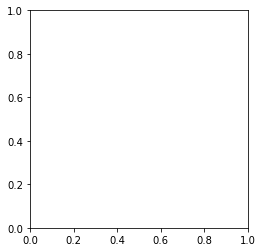

In [16]:
plt.imshow(ndvi[ndvi < 0.6] )